In [28]:
%matplotlib inline

# Dataset

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Shirt  Pullover  Bag  Ankle Boot


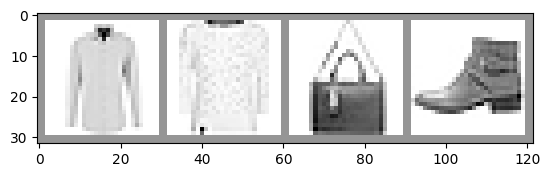

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

# Model

The model we’ll use in this example is a variant of LeNet-5 - it should
be familiar if you’ve watched the previous videos in this series.




In [31]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

model = GarmentClassifier()

## Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration
purposes, we’ll create batches of dummy output and label values, run
them through the loss function, and examine the result.




In [32]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.3440, 0.8935, 0.7452, 0.6550, 0.5936, 0.3402, 0.6458, 0.4663, 0.4907,
         0.2924],
        [0.3396, 0.8240, 0.5065, 0.7969, 0.0369, 0.4926, 0.9307, 0.0121, 0.0261,
         0.8869],
        [0.7594, 0.6954, 0.4748, 0.7437, 0.5973, 0.0275, 0.3776, 0.6620, 0.1607,
         0.9689],
        [0.3853, 0.1868, 0.6020, 0.8251, 0.3202, 0.9909, 0.5019, 0.3162, 0.8564,
         0.5942]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.261411428451538


# Optimizer

In [33]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Metrics

In [34]:
def accuracy_score(model, val_loader):       
    model.eval()
    with torch.no_grad(): 
        correct, total = 0, 0
        for images, labels in val_loader:            
            test_output = model(images)
            pred_y = torch.max(test_output, dim = 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item() 
            total += pred_y.size(dim = 0)
    
    return correct/total
accuracy_score(model, validation_loader)

0.1

In [66]:
from sklearn.metrics import average_precision_score, f1_score

def macro_averaged_accuracy_score(model, val_loader):
    model.eval()
    true_labels = torch.Tensor()
    predicted_labels = torch.Tensor()
    
    
    with torch.no_grad(): 
        for images, labels in val_loader:
            validation_output = model(images)
            predictions = torch.max(validation_output, dim = 1)[1].data.squeeze()
            predicted_labels = torch.cat((predicted_labels, predictions))
            true_labels = torch.cat((true_labels, labels))
            
    return f1_score([1,2,3,2], [1,2,3,3])
        
macro_averaged_accuracy_score(model, validation_loader) 

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# Training pipeline

In [35]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
    
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print(f'Loss after sample {i + 1}: {last_loss}')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    
    return last_loss

In [36]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 3

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # Set the model to evaluation mode, disabling dropout and using population 
    # statistics for batch normalization.
    model.eval()
    running_vloss = 0.0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print("#############################################################")
    print("Epoch results")
    print(f'Loss train {avg_loss} valid loss: {avg_vloss}')
    validation_accuracy = accuracy_score(model, validation_loader)
    train_accuracy = None
    print(f'Accuracy train {train_accuracy} valid accuracy {validation_accuracy}')
    print("#############################################################\n\n")
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    
    writer.add_scalars('Accuracy',
                    { 'Validation accuracy' : validation_accuracy},
                    epoch_number + 1)
    
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
Sample (1000,) loss: 1.8058394292965532
Sample (2000,) loss: 0.9147078606933355
Sample (3000,) loss: 0.7403633297905325
Sample (4000,) loss: 0.6858506467612461
Sample (5000,) loss: 0.6130340623483062
Sample (6000,) loss: 0.5634890499399043
Sample (7000,) loss: 0.5426104303358589
Sample (8000,) loss: 0.5254134572941112
Sample (9000,) loss: 0.4902106414614245
Sample (10000,) loss: 0.4972792391187977
Sample (11000,) loss: 0.4766199467619881
Sample (12000,) loss: 0.4651701233551139
Sample (13000,) loss: 0.4476124069169164
Sample (14000,) loss: 0.43737198541482214
Sample (15000,) loss: 0.4219488693092135
#############################################################
Epoch results
Loss train 0.4219488693092135 valid loss: 0.42712998390197754
Accuracy train None valid accuracy 0.8449
#############################################################
EPOCH 2:
Sample (1000,) loss: 0.40847717969981023
Sample (2000,) loss: 0.40496539729990766
Sample (3000,) loss: 0.4089880636719754
Sample (400

In [68]:
from sklearn.metrics import precision_score
y_true = [1,2,1,2,2]
y_pred = [1,2,1,2,1]
precision_score(y_true, y_pred, average='macro')

0.8333333333333333